# DyGIE++ co-occurrence entity characterization and grounding

In [1]:
import networkx as nx
from collections import defaultdict, Counter
import taxoniq
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import json
import pandas as pd
import timeit
from functools import partial
import seaborn as sns

## Read in data

In [2]:
graph = nx.read_graphml('../data/kg/all_drought_dt_co_occurrence_graph_03Jun2024.graphml')

## Basic characterization

In [3]:
ents_by_type = defaultdict(list)
for n, attrs in graph.nodes(data=True):
    ents_by_type[attrs['ent_type']].append(n)

In [4]:
print(f'{100*(len(ents_by_type["Multicellular_organism"])/len(graph.nodes)):.2f}% of all entities are Multicellular_organism.')

46.65% of all entities are Multicellular_organism.


### Check database grounding potential for `Multi`- and `Unicellular_organism` types

In [6]:
grounded_multicell = {}
for n in ents_by_type['Multicellular_organism']:
    try:
        t = taxoniq.Taxon(scientific_name=n)
        grounded_multicell[n] = t.scientific_name
    except KeyError:
        continue
print(f'{len(grounded_multicell)} of {len(ents_by_type["Multicellular_organism"])} multicellular organisms could be grounded')

14 of 156040 multicellular organisms could be grounded


In [7]:
grounded_unicell = {}
for n in ents_by_type['Unicellular_organism']:
    try:
        t = taxoniq.Taxon(scientific_name=n)
        grounded_unicell[n] = t.scientific_name
    except KeyError:
        continue
print(f'{len(grounded_unicell)} of {len(ents_by_type["Unicellular_organism"])} unicellular organisms could be grounded')

0 of 3260 unicellular organisms could be grounded


Grounding capacity directly using taxoniq is horrendous. What happens if we concatenate all of the species mentions together and use TaxoNERD, like we did for citation network classification? We're going to write a mini script and submit this as a job, because TaxoNERD grounding is exceedingly slow.

In [5]:
# with open('../data/kg/full_graph_multicellular_ents_13Jun2024.txt', 'w') as f:
#     f.write("\n".join(ents_by_type['Multicellular_organism']))

In [9]:
with open('../data/kg/full_graph_multicellular_ents_GROUNDED_13Jun2024.json') as f: ## TODO redo with updated groundings
    grounded_ents = json.load(f)

In [10]:
print(f'There are {len(grounded_ents)} that received a grounding, and {len(set(grounded_ents.values()))} unique groundings.')

There are 51404 that received a grounding, and 21433 unique groundings.


In [11]:
print(f'This means that {100*(len(grounded_ents)/len(graph.nodes)):.2f}% of all nodes have a grounding, and '
     f'{100*(len(grounded_ents))/len(ents_by_type["Multicellular_organism"]):.2f}% of Multicellular_organism nodes have a grounding.')

This means that 15.37% of all nodes have a grounding, and 32.94% of Multicellular_organism nodes have a grounding.


This is great news! It means that a bunch of entities got resolved, even though we didn't get groundings for many of the entities.

In [19]:
groundings_to_ents = defaultdict(list)
for ent, grd in grounded_ents.items():
    groundings_to_ents[grd].append(ent)

### Appearance of study organisms over time
We'll get the top twenty species in the graph based on both the number of mentions of each node, as well as the number of different nodes with the same Taxonomy ID, and then look at when they appear over time. We'll sum the mentions for any entities that resolve to the same grounded TaxonID.

In [12]:
ent_mentions = nx.get_node_attributes(graph, 'num_doc_mentions_all_time')
multi_mentions = {ent: ent_mentions[ent] for ent in ents_by_type['Multicellular_organism']}

In [13]:
organism_year_mentions = {}
for organism in multi_mentions.keys():
    year_mentions = {}
    attrs = graph.nodes[organism]
    for attr, val in attrs.items():
        if ('num_mentions_' in attr) and (attr != 'num_doc_mentions_all_time'):
            year = attr.split('_')[-1]
            if year != '2023':
                year_mentions[int(year)] = val
    organism_year_mentions[organism] = year_mentions

In [14]:
# Resolve them
resolved_groups = defaultdict(list)
for org, year_mentions in organism_year_mentions.items():
    if org in grounded_ents.keys():
        try:
            sci_name = taxoniq.Taxon(int(grounded_ents[org])).scientific_name
            resolved_groups[sci_name].append(year_mentions)
        except KeyError:
            resolved_groups[org].append(year_mentions)
    else:
        resolved_groups[org].append(year_mentions)

resolved_mentions = {}
for org, mention_dicts in resolved_groups.items():
    if len(mention_dicts) == 1:
        resolved_mentions[org] = mention_dicts[0]
    else:
        combined = Counter()
        for i in mention_dicts:
            combined += Counter(i)
        resolved_mentions[org] = combined

In [15]:
top_twenty_resolved = dict(sorted(resolved_mentions.items(), key=lambda x:sum(x[1].values()), reverse=True)[:20])

In [16]:
cmap = matplotlib.cm.get_cmap('tab20c')
organism_colors_resolved = {organism: rgb2hex(cmap(i)) for i, organism in enumerate(top_twenty_resolved.keys())}

/tmp/local/36262614/ipykernel_26814/2909574117.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('tab20c')


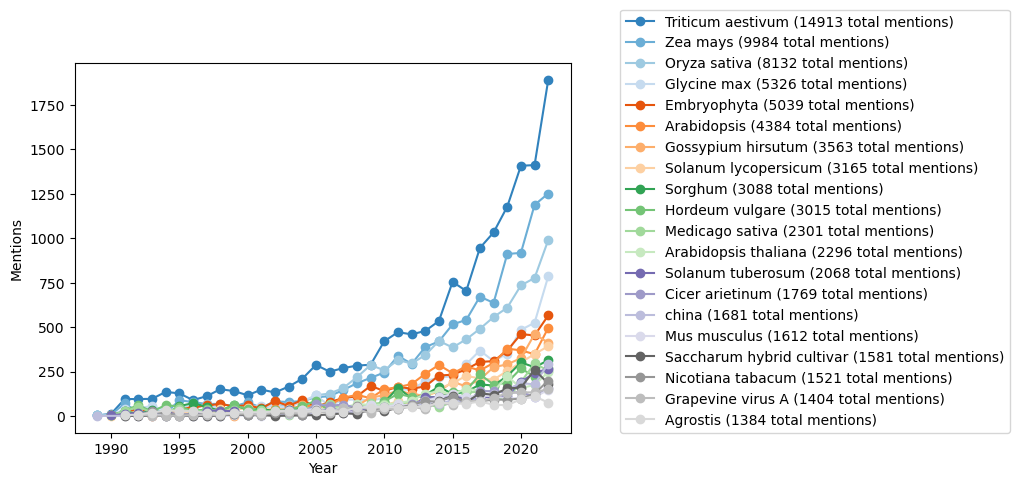

In [17]:
for org in top_twenty_resolved.keys():
    x = sorted(resolved_mentions[org].keys())
    y = [resolved_mentions[org][i] for i in x]
    color = organism_colors_resolved[org]
    plt.plot(x, y, color=color, marker='o', label=f'{org} ({sum(top_twenty_resolved[org].values())} total mentions)')
plt.xlabel('Year')
plt.ylabel('Mentions')
plt.legend(loc=(1.1,0.0))

Embryophyta seems too high-level of a classification to be mentioned that often:

In [20]:
groundings_to_ents['3193'][:20]

['apple plants',
 'tea plants',
 'potato plants',
 'pros plants',
 'tomato plants',
 'cam plants',
 'radish plants',
 'era1 plants',
 'rice plants',
 'c-3 plants',
 'striga plants',
 'rosaceae plants',
 'ots plants',
 'olive plants',
 'dicot plants',
 'aet plants',
 'gh plants',
 'bv plants',
 'cotton plants',
 'pea plants']

Yep, anything with "plants" is classified as Embryophyta.

Seems odd that a virus would appear in the top twenty, what's going on there?

In [21]:
groundings_to_ents['35288'][:20]

['grapevines',
 'wine grapevines',
 'grapevine',
 'grapevine clones',
 'grapevine cv',
 'grapevine cv .',
 'bobal grapevine',
 'di grapevines',
 'grapevine plants',
 'grapevine block',
 'mature grapevines',
 '| grapevine',
 'grapevine species',
 'grapevine wue',
 '| grapevines',
 'babic grapevine',
 'grapevine |',
 "grapevine 's",
 'sultana grapevine',
 'grapevine | viticulture']

Looks like "grapevine" get's normalized to the virus because grapevine isn't a listed common name for grape in Taxonomy.

Another suspicoius thing: what is up with mice appearing in the top 20 of organisms?

In [22]:
groundings_to_ents['10090'][:20]

['transgenic rice plants',
 'transgenic rice',
 'transgenic plants',
 'transgenic tomato',
 'transgenic lines',
 'transgenic lettuce',
 'transgenic rice lines',
 'transgenic rice cultivars',
 'transgenic clones',
 'transgenic arabidopsis and rice',
 'transgenic canola',
 'transgenic plant',
 'transgenic apple',
 'transgenic poplar',
 'transgenic mice',
 'tolerant transgenic rice',
 'transgenic line',
 'non-transgenic rice',
 'transgenic calli',
 'transgenic p. patens']

Apparently, anything that contains the word "transgenic" gets mapped to mice, which is... absolutely bizzare. We'll remove Mus musculus from the top 20, as well as Embryophyta, China and Grapevine.

In [23]:
del top_twenty_resolved['Grapevine virus A']
del top_twenty_resolved['Embryophyta']
del top_twenty_resolved['china']
del top_twenty_resolved['Mus musculus']

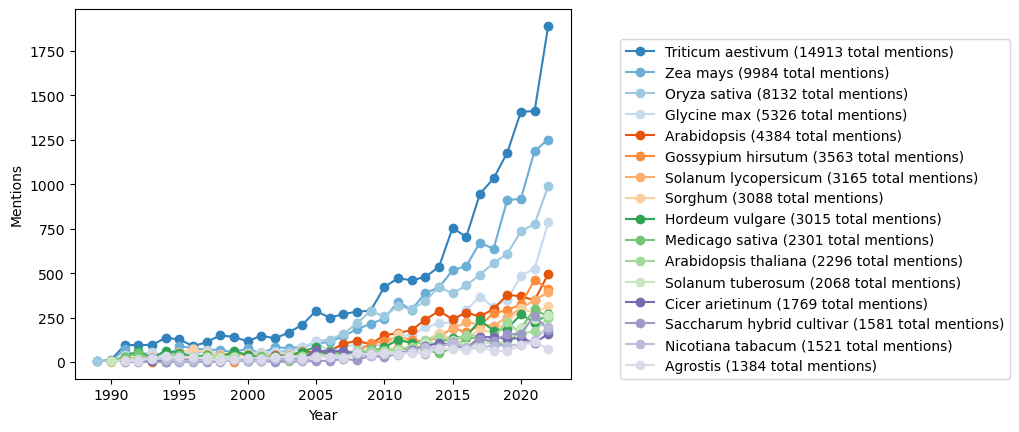

In [24]:
organism_colors_resolved = {organism: rgb2hex(cmap(i)) for i, organism in enumerate(top_twenty_resolved.keys())}
for org in top_twenty_resolved.keys():
    x = sorted(resolved_mentions[org].keys())
    y = [resolved_mentions[org][i] for i in x]
    color = organism_colors_resolved[org]
    plt.plot(x, y, color=color, marker='o', label=f'{org} ({sum(top_twenty_resolved[org].values())} total mentions)')
plt.xlabel('Year')
plt.ylabel('Mentions')
plt.legend(loc=(1.1,0.0))
plt.savefig('../data/figures/top_16_species_mentions.pdf', format='pdf', bbox_inches='tight', dpi=600)

## Growth of types over time
Another thing we can look at is the growth of each entity type over time, to see if they all display similar growth patterns or not. Note that the Multicellular_entities are not normalized here, as contracting the graph relations around the entities proved too computationally complex at scale.

In [25]:
ent_type_years = defaultdict(list)
for n, attrs in graph.nodes(data=True):
    ent_type_years[attrs['ent_type']].append(attrs['first_year_mentioned'])
ent_type_years = {k: Counter(v) for k, v in ent_type_years.items()}

In [26]:
nodes_per_year = defaultdict(list)
for n, attrs in graph.nodes(data=True):
    nodes_per_year[int(attrs['first_year_mentioned'])].append(n)
nodes_per_year = {k: len(v) for k, v in nodes_per_year.items()}
del nodes_per_year[2023]

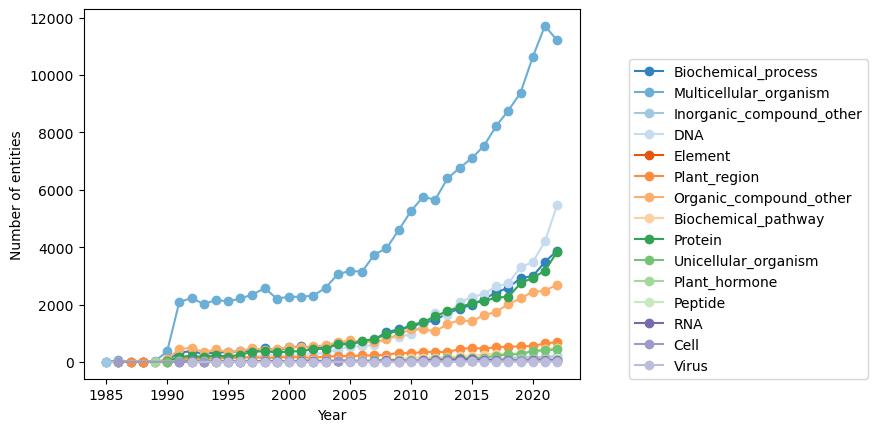

In [27]:
etype_colors = {etype: rgb2hex(cmap(i)) for i, etype in enumerate(ent_type_years.keys())}
for etype, years in ent_type_years.items():
    del years['2023']
    x = sorted(years.keys())
    y = [years[i] for i in x]
    color = etype_colors[etype]
    plt.plot([int(i) for i in x], y, color=color, marker='o', label=f'{etype}')
# plt.plot(sorted(nodes_per_year.keys()), [nodes_per_year[k] for k in sorted(nodes_per_year.keys())], color='grey', label='All nodes')
plt.xlabel('Year')
plt.ylabel('Number of entities')
plt.legend(loc=(1.1,0.0))
plt.savefig('../data/figures/entity_type_growth.pdf', format='pdf', bbox_inches='tight', dpi=600)

In [28]:
growth_traj_groups = {
    0: ['Multicellular_organism'],
    1: ['Biochemical_process', 'DNA', 'Protein', 'Organic_compount_other'],
    2: ['Inorganic_compound_other', 'Element', 'Plant_region', 'Biochemical_pathway', 'Unicellular_organism', 'Plant_hormone', 'Peptide', 'RNA', 'Cell', 'Virus']
}

## Degree per type over time

What if we look at the growth of degree over time? We can use the mean degree per type in a given year.

However, this is a little more complicated, because we need to slice the graph at each year so we can re-calculate degree for each type in each year -- we can't just use the data in the final static snapshot of the graph.

In [29]:
all_years = set([int(attrs['first_year_mentioned']) for n, attrs in graph.nodes(data=True)])

In [30]:
deg_growth = {}
for year in tqdm(all_years):
    year_subgraph = graph.copy()
    nodes_to_remove = [n for n, attrs in graph.nodes(data=True) if int(attrs['first_year_mentioned']) > year]
    _ = year_subgraph.remove_nodes_from(nodes_to_remove)
    deg_by_type = defaultdict(list)
    for n, attrs in year_subgraph.nodes(data=True):
        deg_by_type[attrs['ent_type']].append(year_subgraph.degree(n))
    deg_growth[year] = deg_by_type

  0%|          | 0/39 [00:00<?, ?it/s]

In [31]:
plottable_deg_growth = {}
for etype in deg_growth[2022].keys():
    mean_etype_deg = {}
    for year, dgs in deg_growth.items():
        try:
            mean_etype_deg[year] = sum(dgs[etype])/len(dgs[etype])
        except ZeroDivisionError:
            continue
    plottable_deg_growth[etype] = mean_etype_deg

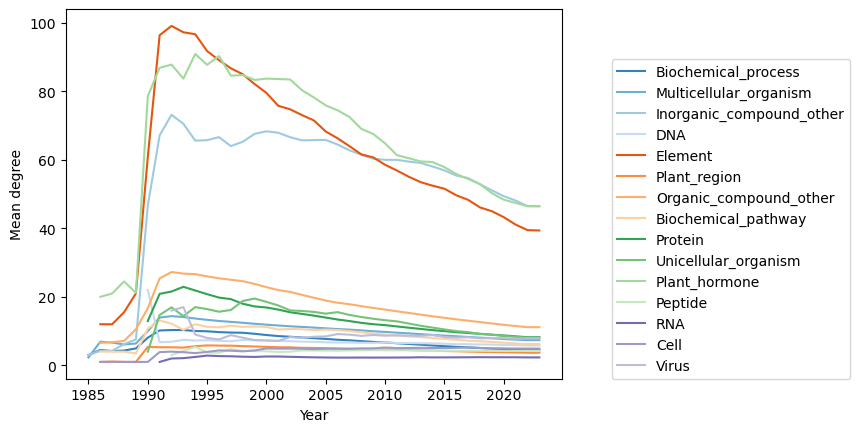

In [32]:
etype_colors = {etype: rgb2hex(cmap(i)) for i, etype in enumerate(ent_type_years.keys())}
for etype, years in plottable_deg_growth.items():
    x = sorted(years.keys())
    y = [years[i] for i in x]
    color = etype_colors[etype]
    plt.plot([int(i) for i in x], y, color=color, label=f'{etype}')
plt.xlabel('Year')
plt.ylabel('Mean degree')
plt.legend(loc=(1.1,0.0))
plt.savefig('../data/figures/entity_type_degree_growth.pdf', format='pdf', bbox_inches='tight', dpi=600)